In [ ]:
! pip install ftfy regex
! pip install git+https://github.com/openai/CLIP.git
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9coyu4jd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9coyu4jd
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=fda2c7f748e899489b0842a4a6a502beed3680c461d723531be0db685610c015
  Stored in directory: /tmp/pip-ephem-wheel-cache-rxpa2ron/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import os
import pandas as pd

import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.optim as optim
from collections import OrderedDict
from torch.optim import AdamW
from pkg_resources import packaging
import torch.nn.functional as F
#from pkg_resources import packaging
import clip

/tmp/ipython-input-1598206480.py:18: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [ ]:
!git clone https://github.com/ttumyche/AI504_Practice14.git
!mv AI504_Practice14/simple_tokenizer.py /content/
!mv AI504_Practice14/bpe_simple_vocab_16e6.txt.gz /content/

Cloning into 'AI504_Practice14'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 1.30 MiB | 16.61 MiB/s, done.


In [ ]:
from simple_tokenizer import SimpleTokenizer
def tokenize_text(tokenizer, text, max_length):
    tokens = tokenizer.encode(text)
    if len(tokens) == 0:
        print(f"Empty tokens for text: {text}")
        return torch.tensor([], dtype=torch.long)

    tokens = tokens[:max_length]
    if len(tokens) < max_length:
        tokens.extend([0] * (max_length - len(tokens)))

    return torch.tensor(tokens, dtype=torch.long)

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [ ]:
#!dir datasets
#!mkdir datasets
!unzip /content/Flickr8k_Dataset.zip
!unzip /content/Flickr8k_text.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch

from PIL import Image
import os
import pandas as pd



class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_file, split_file, transform=None, tokenizer=None, max_length=77):
        # Load and prepare data
        self.image_dir = image_dir
        self.df = pd.read_csv(captions_file, sep='\t', names=['image', 'caption'])
        self.split_file = pd.read_csv(split_file, names=['image'])

        # Filter dataset based on split
        self.df['image'] = self.df['image'].apply(lambda x: x.split('#')[0])
        self.df = self.df[self.df['image'].isin(self.split_file['image'])]

        # Remove empty captions
        self.df = self.df[self.df['caption'].str.strip() != '']

        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        caption = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        if self.tokenizer:
            caption = tokenize_text(self.tokenizer, caption, self.max_length)
            if len(caption) == 0:
                print(f"Empty caption at index {idx}: {self.df.iloc[idx, 1]}")
        else:
            caption = torch.tensor([], dtype=torch.long)

        return image, caption
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])


In [ ]:
#import clip
#tokenizer = clip.tokenize
tokenizer = SimpleTokenizer()

In [ ]:
train_dataset = Flickr8kDataset(
    image_dir='Flicker8k_Dataset',
    captions_file='Flickr8k.token.txt',
    split_file='Flickr_8k.trainImages.txt',
    transform=transform,
    tokenizer=tokenizer,
    max_length=77
)

dev_dataset = Flickr8kDataset(
    image_dir='Flicker8k_Dataset',
    captions_file='Flickr8k.token.txt',
    split_file='Flickr_8k.devImages.txt',
    transform=transform,
    tokenizer=tokenizer,
    max_length=77
)

test_dataset = Flickr8kDataset(
    image_dir='Flicker8k_Dataset',
    captions_file='Flickr8k.token.txt',
    split_file='Flickr_8k.testImages.txt',
    transform=transform,
    tokenizer=tokenizer,
    max_length=77
)
train_dataloader = DataLoader(train_dataset, batch_size=28, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=28, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=28, shuffle=True)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, transformer_width, transformer_heads, transformer_layers, context_length, embed_dim):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.zeros(context_length, transformer_width))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=transformer_width, nhead=transformer_heads),
            num_layers=transformer_layers
        )
        self.ln_final = nn.LayerNorm(transformer_width)
        self.text_projection = nn.Linear(transformer_width, embed_dim)

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.02)
        nn.init.normal_(self.text_projection.weight, std=0.02)

    def forward(self, text):
        x = self.token_embedding(text)  # [batch_size, seq_len, transformer_width]
        x = x + self.positional_embedding[:x.size(1), :]

        x = x.permute(1, 0, 2)  # [seq_len, batch_size, transformer_width]
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # [batch_size, seq_len, transformer_width]

        eot_token_idx = (text != 0).int().cumsum(dim=1).argmax(dim=1) # Find index of the eot(end-of-text), padding token(0)
        x = x[torch.arange(x.shape[0]), eot_token_idx] # [batch_size, transformer_width]

        x = self.text_projection(x) # [batch_size, embed_dim]

        return x



In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        self.num_patches = (input_resolution // patch_size) ** 2
        self.positional_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, width))
        self.class_embedding = nn.Parameter(torch.zeros(1, 1, width))

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=width, nhead=heads),
            num_layers=layers
        )

        self.fc = nn.Linear(width, output_dim)

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.positional_embedding, std=0.02)
        nn.init.normal_(self.class_embedding, std=0.02)
        nn.init.normal_(self.fc.weight, std=0.02)

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # [batch_size, width, grid, grid]
        x = x.flatten(2)   # [batch_size, width, num_patches (grid x grid)]
        x = x.transpose(1, 2)  # [batch_size, num_patches, width]

        class_embeddings = self.class_embedding.expand(x.shape[0], -1, -1)  # [batch_size, 1, width]
        x = torch.cat([class_embeddings, x], dim=1)  # [batch_size, num_patches + 1, width]
        x = x + self.positional_embedding


        x = self.transformer(x.permute(1, 0, 2))  # [seq_len, batch_size, width]
        x = x.permute(1, 0, 2)  # [batch_size, seq_len, width]

        x = self.fc(x[:, 0]) # [batch_size, output_dim]
        return x


In [ ]:
class CLIP(nn.Module):
    def __init__(self, embed_dim, image_resolution, vision_layers, vision_width, vision_patch_size, context_length, vocab_size, transformer_width, transformer_heads, transformer_layers):
        super().__init__()

        self.image_encoder = ImageEncoder(
            input_resolution=image_resolution,
            patch_size=vision_patch_size,
            width=vision_width,
            layers=vision_layers,
            heads=transformer_heads,
            output_dim=embed_dim
        )
        self.text_encoder = TextEncoder(
            vocab_size=vocab_size,
            transformer_width=transformer_width,
            transformer_heads=transformer_heads,
            transformer_layers=transformer_layers,
            context_length=context_length,
            embed_dim=embed_dim
        )

        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, image, text):
        image_features = self.image_encoder(image)
        text_features = self.text_encoder(text)

        if image_features.dim() < 2:
            image_features = image_features.unsqueeze(0)
        if text_features.dim() < 2:
            text_features = text_features.unsqueeze(0)

        return image_features, text_features


In [ ]:
image_resolution = 224
vision_patch_size = 16
vision_width = 768
vision_layers = 4
vision_heads = 12
embed_dim = 128
context_length = 77
vocab_size = 49408
transformer_width = 512
transformer_heads = 8
transformer_layers = 6

model = CLIP(
    embed_dim=embed_dim,
    image_resolution=image_resolution,
    vision_layers=vision_layers,
    vision_width=vision_width,
    vision_patch_size=vision_patch_size,
    context_length=context_length,
    vocab_size=vocab_size,
    transformer_width=transformer_width,
    transformer_heads=transformer_heads,
    transformer_layers=transformer_layers
)

optimizer = optim.AdamW(model.parameters(), lr=1e-3)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
def contrastive_loss(image_features, text_features, temperature=0.07):
    # Ensure inputs are on the same device
    device = image_features.device

    # Normalize features
    image_features = F.normalize(image_features, dim=1)
    text_features = F.normalize(text_features, dim=1)

    # Cosine similarity as logits
    logits = torch.matmul(image_features, text_features.t()) / temperature
    labels = torch.arange(logits.shape[0], dtype=torch.long, device=device)

    # Cross-entropy loss for image-to-text and text-to-image
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.t(), labels)

    return (loss_i2t + loss_t2i) / 2


In [ ]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch_idx, (images, captions) in enumerate(dataloader):
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        image_features, text_features = model(images, captions)

        loss = contrastive_loss(image_features, text_features)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 50 == 0:  # Print every 10 batches
            print(f"Batch {batch_idx+1}/{len(dataloader)}, Batch Loss: {loss.item()}")
    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions in dataloader:
            images, captions = images.to(device), captions.to(device)

            image_features = model.image_encoder(images)
            text_features = model.text_encoder(captions)

            if text_features is None:
              raise ValueError("text_features is None after encode_text")

            loss = contrastive_loss(image_features, text_features)
            total_loss += loss.item()

    return total_loss / len(dataloader)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1
best_val_loss = float('inf')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_dataloader, optimizer, device)
    val_loss = validate(model, dev_dataloader, device)

    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, 'best_clip_model.pth')

    # Early stopping
    if optimizer.param_groups[0]['lr'] < 1e-4:
        print("Learning rate too small, stopping training")
        break



Epoch 1/1
Batch 50/1072, Batch Loss: 3.3362112045288086
Batch 100/1072, Batch Loss: 3.335665702819824
Batch 150/1072, Batch Loss: 3.333678722381592
Batch 200/1072, Batch Loss: 3.334653377532959
Batch 250/1072, Batch Loss: 3.3356099128723145
Batch 300/1072, Batch Loss: 3.333646535873413
Batch 350/1072, Batch Loss: 3.3291735649108887
Batch 400/1072, Batch Loss: 3.332611322402954
Batch 450/1072, Batch Loss: 3.3326125144958496
Batch 500/1072, Batch Loss: 3.3321995735168457
Batch 550/1072, Batch Loss: 3.331571578979492
Batch 600/1072, Batch Loss: 3.3308358192443848
Batch 650/1072, Batch Loss: 3.333592653274536
Batch 700/1072, Batch Loss: 3.33469295501709
Batch 750/1072, Batch Loss: 3.332359552383423
Batch 800/1072, Batch Loss: 3.3332676887512207
Batch 850/1072, Batch Loss: 3.3350095748901367
Batch 900/1072, Batch Loss: 3.334350109100342
Batch 950/1072, Batch Loss: 3.331101894378662
Batch 1000/1072, Batch Loss: 3.329615592956543
Batch 1050/1072, Batch Loss: 3.3373539447784424
Training Loss:

In [ ]:
checkpoint = torch.load('best_clip_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
model.eval()

CLIP(
  (image_encoder): ImageEncoder(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (fc): Linear(in_features=768, out_features=128, bias=True)
  )
  (text_encoder): TextEncoder(
    (token_embedding): Embedding(49408, 5

**Reasoning**:
Evaluate the loaded model on the test dataset using R@1, R@5, and R@10 metrics for both image-to-text and text-to-image retrieval.



In [ ]:
total_images = 0
total_texts = 0
correct_i2t_r1 = 0
correct_i2t_r5 = 0
correct_i2t_r10 = 0
correct_t2i_r1 = 0
correct_t2i_r5 = 0
correct_t2i_r10 = 0

with torch.no_grad():
    for images, captions in test_dataloader:
        images, captions = images.to(device), captions.to(device)

        image_features = model.image_encoder(images)
        text_features = model.text_encoder(captions)

        # Normalize features
        image_features = F.normalize(image_features, dim=1)
        text_features = F.normalize(text_features, dim=1)

        # Cosine similarity as logits
        logits = torch.matmul(image_features, text_features.t())

        batch_size = images.size(0)
        total_images += batch_size
        total_texts += batch_size

        # Image-to-Text Retrieval
        sorted_indices_i2t = torch.argsort(logits, dim=1, descending=True)
        for i in range(batch_size):
            correct_index = i
            if correct_index in sorted_indices_i2t[i, :1]:
                correct_i2t_r1 += 1
            if correct_index in sorted_indices_i2t[i, :5]:
                correct_i2t_r5 += 1
            if correct_index in sorted_indices_i2t[i, :10]:
                correct_i2t_r10 += 1

        # Text-to-Image Retrieval
        sorted_indices_t2i = torch.argsort(logits.t(), dim=1, descending=True)
        for i in range(batch_size):
            correct_index = i
            if correct_index in sorted_indices_t2i[i, :1]:
                correct_t2i_r1 += 1
            if correct_index in sorted_indices_t2i[i, :5]:
                correct_t2i_r5 += 1
            if correct_index in sorted_indices_t2i[i, :10]:
                correct_t2i_r10 += 1

r1_i2t = correct_i2t_r1 / total_images
r5_i2t = correct_i2t_r5 / total_images
r10_i2t = correct_i2t_r10 / total_images

r1_t2i = correct_t2i_r1 / total_texts
r5_t2i = correct_t2i_r5 / total_texts
r10_t2i = correct_t2i_r10 / total_texts

print(f"Image-to-Text Retrieval:")
print(f"R@1: {r1_i2t:.4f}")
print(f"R@5: {r5_i2t:.4f}")
print(f"R@10: {r10_i2t:.4f}")

print(f"\nText-to-Image Retrieval:")
print(f"R@1: {r1_t2i:.4f}")
print(f"R@5: {r5_t2i:.4f}")
print(f"R@10: {r10_t2i:.4f}")

Image-to-Text Retrieval:
R@1: 0.0364
R@5: 0.1806
R@10: 0.3538

Text-to-Image Retrieval:
R@1: 0.0358
R@5: 0.1782
R@10: 0.3580


**Reasoning**:
Select a sample batch from the test dataloader, move the data to the device, get the features from the model, compute the similarity matrix, and then find the top-k indices for retrieval.



In [ ]:
# Select a sample batch
sample_images, sample_captions = next(iter(test_dataloader))
sample_images = sample_images.to(device)
sample_captions = sample_captions.to(device)

# Get features
with torch.no_grad():
    sample_image_features = model.image_encoder(sample_images)
    sample_text_features = model.text_encoder(sample_captions)

# Normalize features
sample_image_features = F.normalize(sample_image_features, dim=1)
sample_text_features = F.normalize(sample_text_features, dim=1)

# Compute similarity
similarity_matrix = torch.matmul(sample_image_features, sample_text_features.t()).cpu().numpy()

# Get top-k indices
k = 5
image_to_text_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1][:, :k]
text_to_image_indices = np.argsort(similarity_matrix, axis=0)[::-1, :].T[:, :k]

**Reasoning**:
Display the sample images with their top-k retrieved captions and the sample captions with their top-k retrieved images to visually demonstrate the model's performance.



Image-to-Text Retrieval:

Original Image 1:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: A boy dressed in soccer attire and holding his shoes getting out of a car .
3: A black dog pounces to get a rope toy .
4: Two young girls playing together .
5: Two young girls are playing and laughing in a green grassy yard .


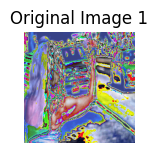


Original Image 2:
Top 5 Retrieved Captions:
1: A black dog pounces to get a rope toy .
2: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
3: a black dog jumping to catch a rope toy
4: A black and white dog carrying a large stick
5: Two young girls playing together .


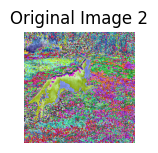


Original Image 3:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: Two young girls playing together .
3: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
4: A dog trots across the ground with a large stick in his mouth .
5: A boy dressed in soccer attire and holding his shoes getting out of a car .


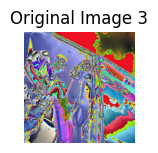


Original Image 4:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: Two young girls playing together .
3: Two children are laughing in the grass .
4: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
5: A black dog pounces to get a rope toy .


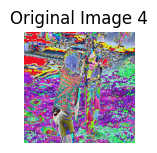


Original Image 5:
Top 5 Retrieved Captions:
1: Two young girls playing together .
2: A black and white dog carrying a large stick
3: Two girls standing on grass face each other .
4: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
5: Two children are laughing in the grass .


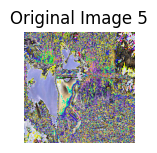


Original Image 6:
Top 5 Retrieved Captions:
1: A boy dressed in soccer attire and holding his shoes getting out of a car .
2: A black and white dog carrying a large stick
3: Two children are laughing in the grass .
4: A black and white dog is carrying a stick in its mouth .
5: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .


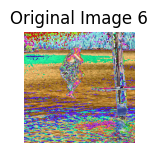


Original Image 7:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: The woman in the blue dress is holding out her arm at oncoming traffic .
3: Two young girls playing together .
4: A black and white dog is carrying a stick in its mouth .
5: A boy dressed in soccer attire and holding his shoes getting out of a car .


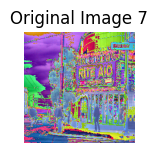


Original Image 8:
Top 5 Retrieved Captions:
1: Two young girls playing together .
2: A black and white dog carrying a large stick
3: A boy dressed in soccer attire and holding his shoes getting out of a car .
4: Two children are laughing in the grass .
5: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .


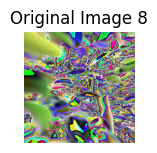


Original Image 9:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: Two young girls playing together .
3: The woman in the blue dress is holding out her arm at oncoming traffic .
4: Two children are laughing in the grass .
5: A dog trots across the ground with a large stick in his mouth .


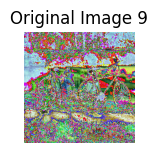


Original Image 10:
Top 5 Retrieved Captions:
1: Two young girls playing together .
2: A black and white dog carrying a large stick
3: a black dog jumping to catch a rope toy
4: Two children are laughing in the grass .
5: Two girls laughing outside in a yard .


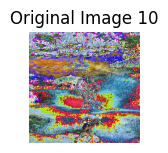


Original Image 11:
Top 5 Retrieved Captions:
1: Two young girls playing together .
2: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
3: A black and white dog carrying a large stick
4: A dog trots across the ground with a large stick in his mouth .
5: Two girls laughing outside in a yard .


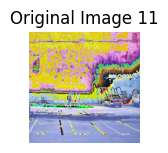


Original Image 12:
Top 5 Retrieved Captions:
1: A dog trots across the ground with a large stick in his mouth .
2: The woman in the blue dress is holding out her arm at oncoming traffic .
3: Two young girls are playing and laughing in a green grassy yard .
4: A black and white dog carrying a large stick
5: A black dog pounces to get a rope toy .


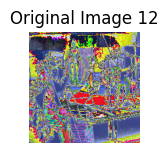


Original Image 13:
Top 5 Retrieved Captions:
1: The woman in the blue dress is holding out her arm at oncoming traffic .
2: A boy dressed in soccer attire and holding his shoes getting out of a car .
3: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
4: A black and white dog is carrying a stick in its mouth .
5: Two girls laughing outside in a yard .


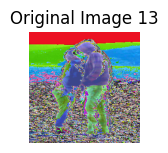


Original Image 14:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: The woman in the blue dress is holding out her arm at oncoming traffic .
3: Two young girls are playing and laughing in a green grassy yard .
4: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
5: Two young girls playing together .


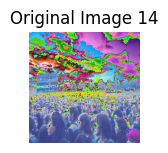


Original Image 15:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
3: Two girls laughing outside in a yard .
4: A dog trots across the ground with a large stick in his mouth .
5: a black dog jumping to catch a rope toy


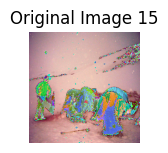


Original Image 16:
Top 5 Retrieved Captions:
1: A boy dressed in soccer attire and holding his shoes getting out of a car .
2: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
3: a black dog jumping to catch a rope toy
4: Two young girls playing together .
5: A dog trots across the ground with a large stick in his mouth .


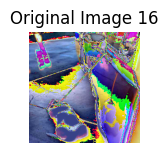


Original Image 17:
Top 5 Retrieved Captions:
1: A black and white dog is carrying a stick in its mouth .
2: A blond woman is on the street hailing a taxi .
3: A boy dressed in soccer attire and holding his shoes getting out of a car .
4: A black dog pounces to get a rope toy .
5: Two children are laughing in the grass .


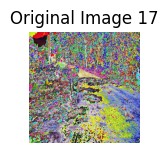


Original Image 18:
Top 5 Retrieved Captions:
1: Two young girls playing together .
2: A black and white dog carrying a large stick
3: A boy dressed in soccer attire and holding his shoes getting out of a car .
4: A dog trots across the ground with a large stick in his mouth .
5: Two girls laughing outside in a yard .


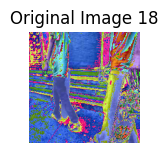


Original Image 19:
Top 5 Retrieved Captions:
1: Two young girls playing together .
2: A black and white dog carrying a large stick
3: A black dog pounces to get a rope toy .
4: The woman in the blue dress is holding out her arm at oncoming traffic .
5: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .


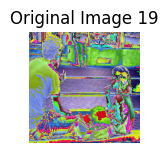


Original Image 20:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: Two children are laughing in the grass .
3: A boy dressed in soccer attire and holding his shoes getting out of a car .
4: A blond woman is on the street hailing a taxi .
5: The woman in the blue dress is holding out her arm at oncoming traffic .


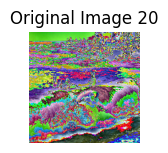


Original Image 21:
Top 5 Retrieved Captions:
1: Two young girls playing together .
2: Two children are laughing in the grass .
3: a black dog jumping to catch a rope toy
4: A black dog pounces to get a rope toy .
5: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .


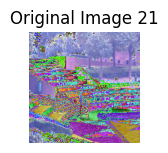


Original Image 22:
Top 5 Retrieved Captions:
1: a black dog jumping to catch a rope toy
2: Two girls laughing outside in a yard .
3: The woman in the blue dress is holding out her arm at oncoming traffic .
4: A black and white dog carrying a large stick
5: Two young girls playing together .


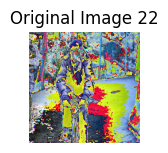


Original Image 23:
Top 5 Retrieved Captions:
1: The woman in the blue dress is holding out her arm at oncoming traffic .
2: A black and white dog carrying a large stick
3: Two children are laughing in the grass .
4: Two young girls playing together .
5: A black dog running after his rope toy .


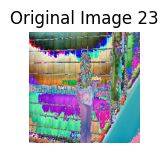


Original Image 24:
Top 5 Retrieved Captions:
1: A boy dressed in soccer attire and holding his shoes getting out of a car .
2: A black and white dog carrying a large stick
3: Two young girls playing together .
4: A dog trots across the ground with a large stick in his mouth .
5: A black dog pounces to get a rope toy .


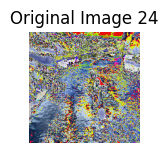


Original Image 25:
Top 5 Retrieved Captions:
1: Two young girls playing together .
2: A black and white dog carrying a large stick
3: A dog trots across the ground with a large stick in his mouth .
4: Two children are laughing in the grass .
5: A child getting out of the car wearing soccer shoes .


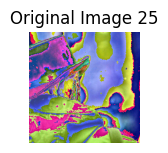


Original Image 26:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: The woman in the blue dress is holding out her arm at oncoming traffic .
3: A boy dressed in soccer attire and holding his shoes getting out of a car .
4: A dog trots across the ground with a large stick in his mouth .
5: Two children are laughing in the grass .


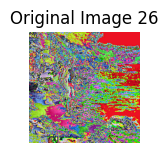


Original Image 27:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: Two young girls playing together .
3: Two children are laughing in the grass .
4: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
5: a black dog jumping to catch a rope toy


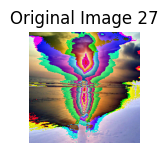


Original Image 28:
Top 5 Retrieved Captions:
1: A black and white dog carrying a large stick
2: Two young girls playing together .
3: Two girls laughing outside in a yard .
4: a black dog jumping to catch a rope toy
5: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .


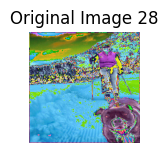


Text-to-Image Retrieval:

Original Caption 1: A blond woman in a blue shirt appears to wait for a ride .
Top 5 Retrieved Images:


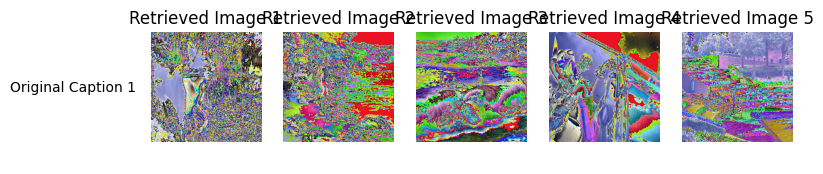


Original Caption 2: A blond woman is on the street hailing a taxi .
Top 5 Retrieved Images:


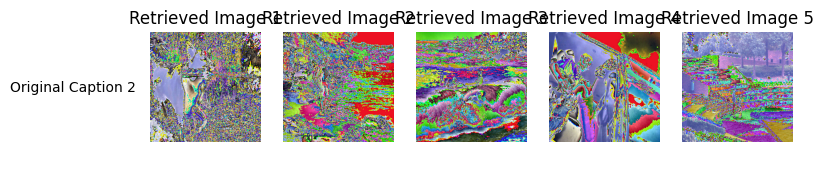


Original Caption 3: A woman is signaling is to traffic , as seen from behind .
Top 5 Retrieved Images:


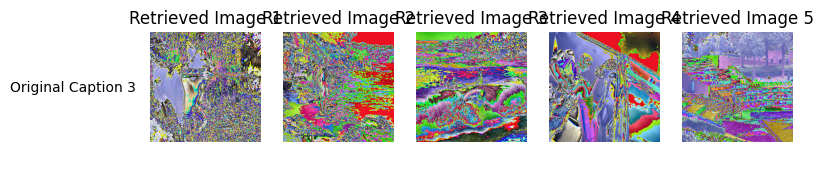


Original Caption 4: A woman with blonde hair wearing a blue tube top is waving on the side of the street .
Top 5 Retrieved Images:


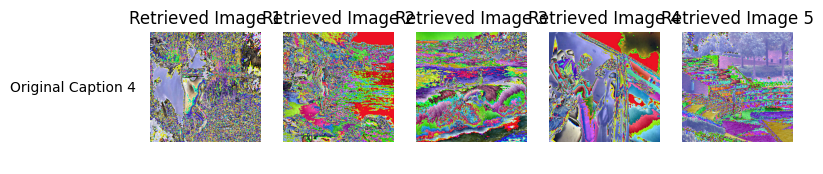


Original Caption 5: The woman in the blue dress is holding out her arm at oncoming traffic .
Top 5 Retrieved Images:


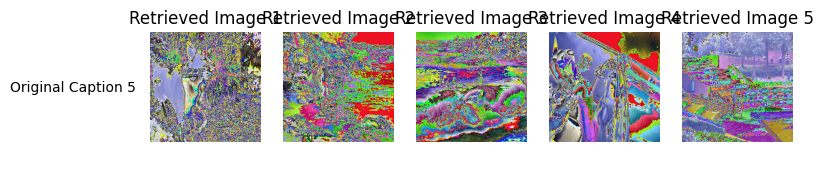


Original Caption 6: a black dog jumping to catch a rope toy
Top 5 Retrieved Images:


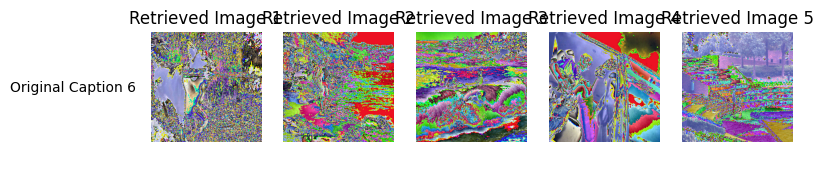


Original Caption 7: A black dog playing fetch with a ball of rope .
Top 5 Retrieved Images:


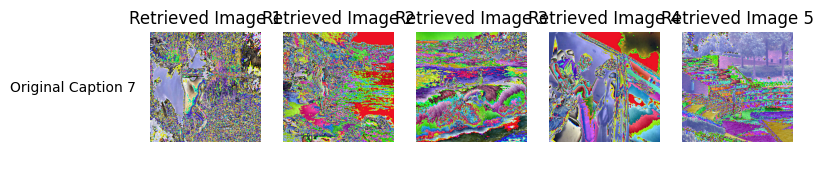


Original Caption 8: A black dog pounces to get a rope toy .
Top 5 Retrieved Images:


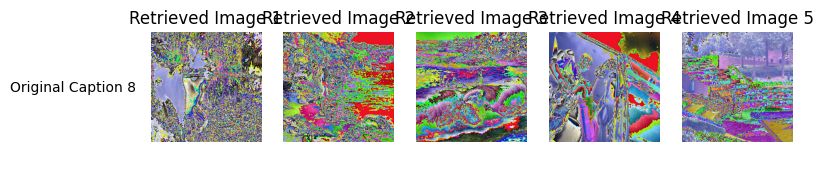


Original Caption 9: A black dog running after his rope toy .
Top 5 Retrieved Images:


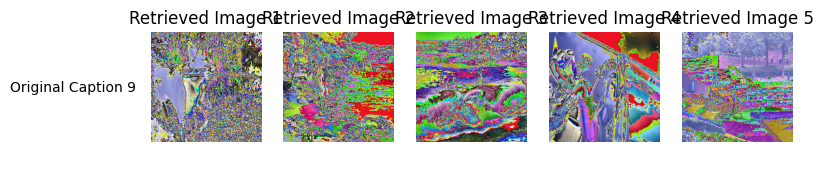


Original Caption 10: A large black dog is playing in a grassy yard .
Top 5 Retrieved Images:


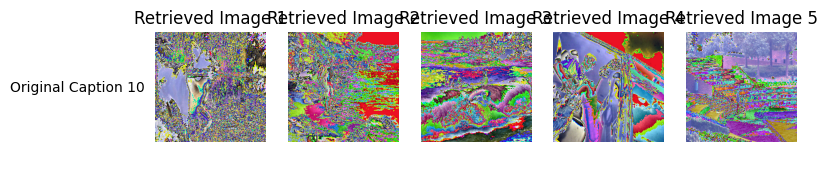


Original Caption 11: A boy dressed in soccer attire and holding his shoes getting out of a car .
Top 5 Retrieved Images:


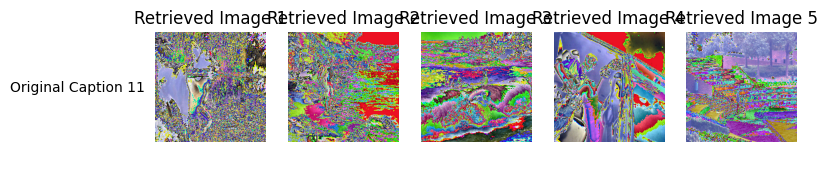


Original Caption 12: A boy in a red soccer strip is holding his boots in his hand whilst stepping out of a car .
Top 5 Retrieved Images:


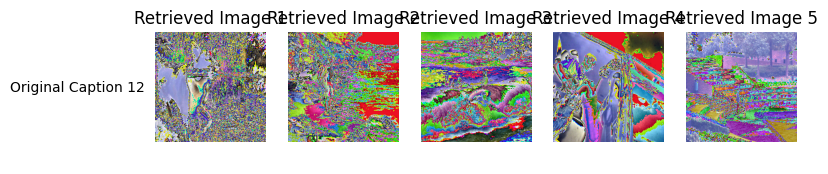


Original Caption 13: A boy in glasses is wearing a red shirt .
Top 5 Retrieved Images:


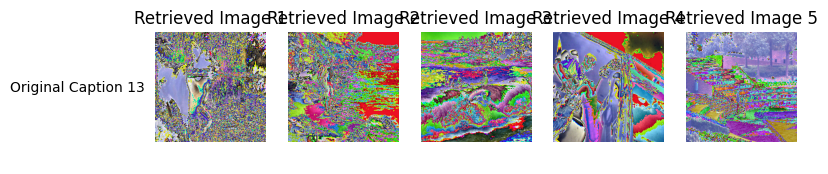


Original Caption 14: A child getting out of the car wearing soccer shoes .
Top 5 Retrieved Images:


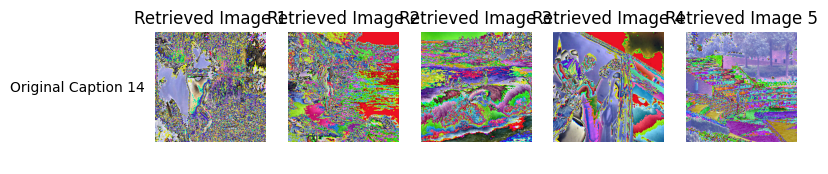


Original Caption 15: A young boy gets out of the van and prepares his shoes for wear during a soccer game .
Top 5 Retrieved Images:


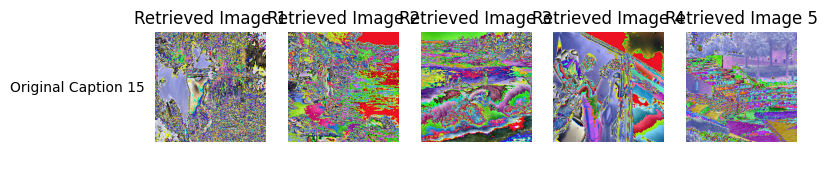


Original Caption 16: Two children are laughing in the grass .
Top 5 Retrieved Images:


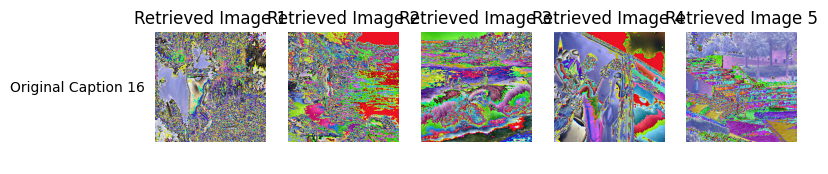


Original Caption 17: Two girls laughing outside in a yard .
Top 5 Retrieved Images:


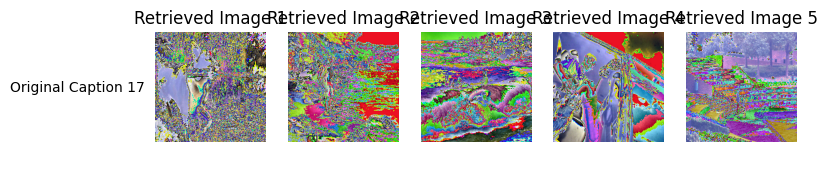


Original Caption 18: Two girls standing on grass face each other .
Top 5 Retrieved Images:


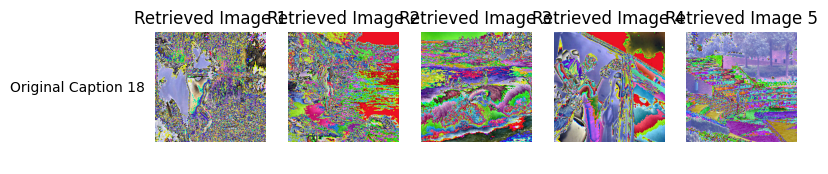


Original Caption 19: Two young girls are playing and laughing in a green grassy yard .
Top 5 Retrieved Images:


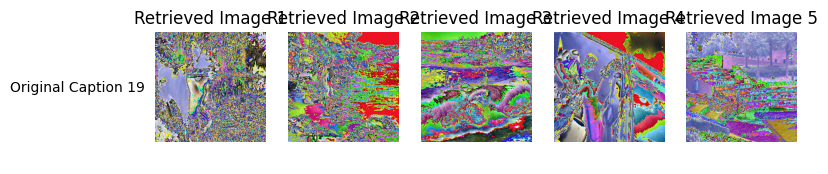


Original Caption 20: Two young girls playing together .
Top 5 Retrieved Images:


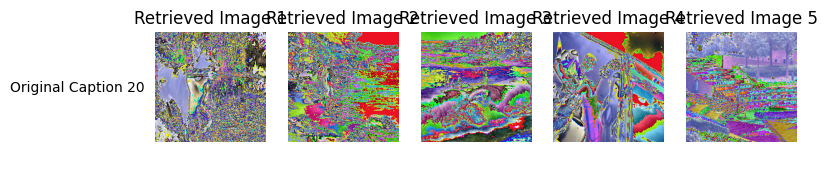


Original Caption 21: A black and white dog carrying a large stick
Top 5 Retrieved Images:


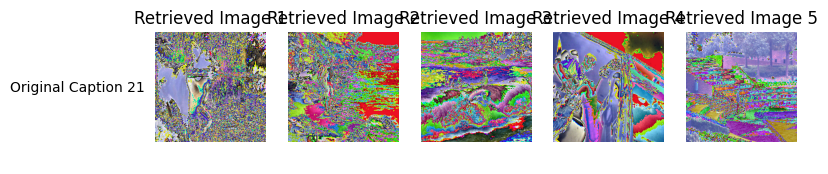


Original Caption 22: A black and white dog is carrying a stick in its mouth .
Top 5 Retrieved Images:


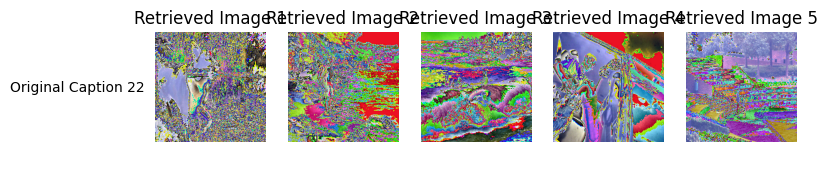


Original Caption 23: a black and white dog walking through the grass with a long stick in his mouth .
Top 5 Retrieved Images:


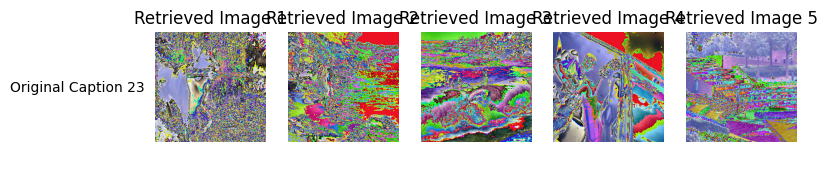


Original Caption 24: a dog holds a stick in its mouth .
Top 5 Retrieved Images:


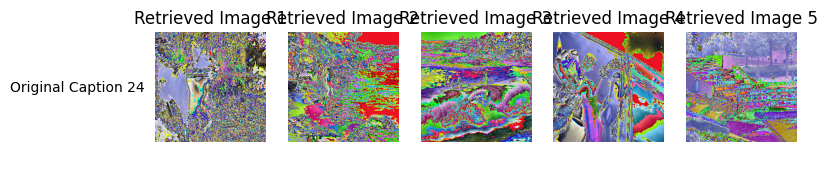


Original Caption 25: A dog trots across the ground with a large stick in his mouth .
Top 5 Retrieved Images:


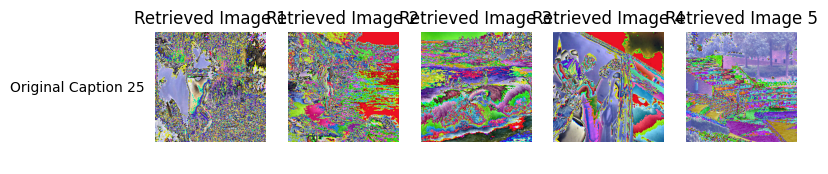


Original Caption 26: A blonde boy wearing a blue life vest and camo shorts jumps off a diveboard into a blue lake .
Top 5 Retrieved Images:


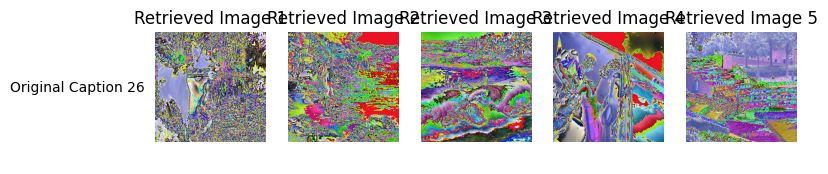


Original Caption 27: A boy diving backward off a pier in a large lake .
Top 5 Retrieved Images:


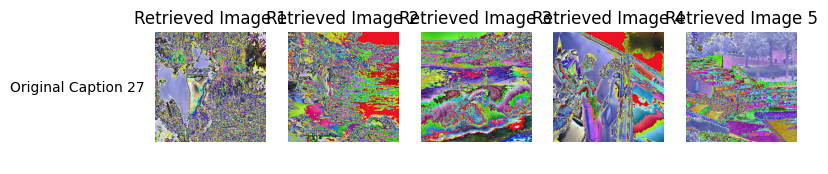


Original Caption 28: A boy in a blue life jacket jumps into the water .
Top 5 Retrieved Images:


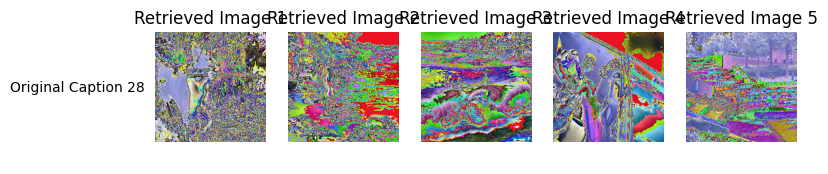

In [ ]:
# Get original images and captions from the dataset for display
sample_images_display = [test_dataset[i*test_dataloader.batch_size][0] for i in range(len(sample_images))]
sample_captions_display = [test_dataset[i*test_dataloader.batch_size][1] for i in range(len(sample_captions))]

# Convert tokenized captions back to text for display (this is a simplified approach)
# A proper BPE decoder would be needed for accurate text reconstruction
# For demonstration, we will use the original text from the dataframe based on indices
original_captions_df = test_dataset.df[test_dataset.df['image'].isin([test_dataset.df.iloc[i*test_dataloader.batch_size, 0] for i in range(len(sample_images))])]['caption'].tolist()


# Display Image-to-Text retrieval
print("Image-to-Text Retrieval:")
for i in range(len(sample_images)):
    plt.figure(figsize=(10, 2))
    plt.subplot(1, k + 1, 1)
    img = transforms.ToPILImage()(sample_images_display[i])
    plt.imshow(img)
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    print(f"\nOriginal Image {i+1}:")
    print("Top 5 Retrieved Captions:")
    for j, text_idx in enumerate(image_to_text_indices[i]):
        # Find the original caption text corresponding to the index in the batch
        # This is a simplified mapping assuming the batch order matches the original dataframe sample
        retrieved_caption_text = original_captions_df[text_idx]
        print(f"{j+1}: {retrieved_caption_text}")

    plt.show()

# Display Text-to-Image retrieval
print("\nText-to-Image Retrieval:")
for i in range(len(sample_captions)):
    plt.figure(figsize=(10, 2))
    print(f"\nOriginal Caption {i+1}: {original_captions_df[i]}")
    print("Top 5 Retrieved Images:")

    plt.subplot(1, k + 1, 1)
    # Display a blank plot for the original caption as we don't have a visual representation
    plt.text(0.5, 0.5, f"Original Caption {i+1}", horizontalalignment='center', verticalalignment='center', wrap=True)
    plt.axis('off')


    for j, img_idx in enumerate(text_to_image_indices[i]):
        plt.subplot(1, k + 1, j + 2)
        # Get the original image corresponding to the index in the batch
        retrieved_image_display = transforms.ToPILImage()(sample_images_display[img_idx])
        plt.imshow(retrieved_image_display)
        plt.title(f"Retrieved Image {j+1}")
        plt.axis('off')
    plt.show()